### Installing Einit :: עינית ::

In [34]:
!pip install "einit[test] @ git+https://github.com/sashakolpakov/einit.git@main"

  Cloning https://github.com/sashakolpakov/einit.git (to revision main) to /tmp/pip-install-t3we4jsl/einit_6347bda40101486585e9041df571a674
  Running command git clone --filter=blob:none --quiet https://github.com/sashakolpakov/einit.git /tmp/pip-install-t3we4jsl/einit_6347bda40101486585e9041df571a674
  Resolved https://github.com/sashakolpakov/einit.git to commit c1fe5a0d27b8d9b7aade969fa074f4dac2f6f708
  Preparing metadata (setup.py) ... done


### Imports and setup

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import timeit
from einit import ellipsoid_init_icp

In [36]:
# Style for the visuals
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('default')

# Random seed for reproducibility
np.random.seed(42)

### Helper functions

In [37]:
def apply_transform(pts, T):
    """Apply a 4x4 homogeneous transform T to an (N,3) array of points."""
    N = pts.shape[0]
    homo = np.hstack([pts, np.ones((N, 1))])
    return (T @ homo.T).T[:, :3]

def random_rigid_transform():
    """Generate a random rigid transformation matrix."""
    A = np.random.normal(size=(3, 3))
    Q, _ = np.linalg.qr(A)
    if np.linalg.det(Q) < 0:
        Q[:, 0] = -Q[:, 0]
    t = np.random.uniform(-5, 5, size=(3,))
    T = np.eye(4)
    T[:3, :3] = Q
    T[:3, 3] = t
    return T

def plot_point_clouds(src, dst, aligned, title="Point Cloud Alignment"):
    """Plot source, destination, and aligned point clouds."""
    fig = plt.figure(figsize=(15, 5))

    # Source points
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(src[:, 0], src[:, 1], src[:, 2], c='red', alpha=0.6, s=20)
    ax1.set_title('Source Points')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    # Destination points
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.scatter(dst[:, 0], dst[:, 1], dst[:, 2], c='blue', alpha=0.6, s=20)
    ax2.set_title('Destination Points')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    # Overlay: destination (blue) and aligned source (red)
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.scatter(dst[:, 0], dst[:, 1], dst[:, 2], c='blue', alpha=0.6, s=20, label='Target')
    ax3.scatter(aligned[:, 0], aligned[:, 1], aligned[:, 2], c='red', alpha=0.6, s=20, label='Aligned Source')
    ax3.set_title('Alignment Result')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')
    ax3.legend()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

    # Calculate alignment error
    error = np.linalg.norm(aligned - dst, axis=1)
    print(f"Mean alignment error: {np.mean(error):.6f}")
    print(f"Max alignment error: {np.max(error):.6f}")
    print(f"RMSE: {np.sqrt(np.mean(error**2)):.6f}")

### Test 1 - Sphere Alignment

=== SPHERE ALIGNMENT TEST ===

ellipsoid_init_icp: 0.006 ms ± 0.006 ms over 1000 runs

True transformation matrix:
[[-0.94697059  0.0677149   0.31410412  0.50531681]
 [ 0.08816818 -0.8852626   0.45665796 -0.92634476]
 [ 0.30898718  0.46013565  0.83234735  0.21377021]
 [ 0.          0.          0.          1.        ]]

Estimated transformation matrix:
[[-0.94770937  0.06078193  0.31329301  0.5057089 ]
 [ 0.09445238 -0.88429309  0.45727943 -0.92719658]
 [ 0.30483717  0.46295927  0.83231185  0.21266601]
 [ 0.          0.          0.          1.        ]]


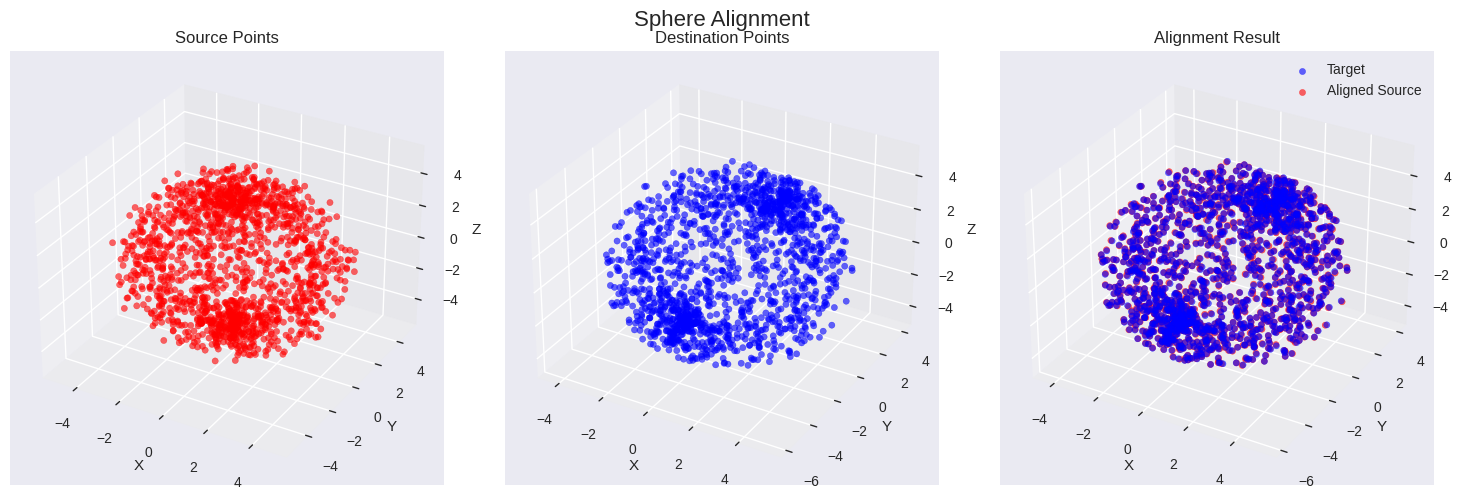

Mean alignment error: 0.037798
Max alignment error: 0.102799
RMSE: 0.041307


In [38]:
print("=== SPHERE ALIGNMENT TEST ===")

# Generate sphere points
n_points = 1500
phi = np.random.uniform(0, np.pi, n_points)
theta = np.random.uniform(0, 2*np.pi, n_points)
src_sphere = np.vstack([
    np.sin(phi) * np.cos(theta),
    np.sin(phi) * np.sin(theta),
    np.cos(phi)
]).T
src_sphere *= np.random.uniform(3, 5, size=(n_points, 1))

# Apply random transformation
T_true = random_rigid_transform()
dst_sphere = apply_transform(src_sphere, T_true)

# Add small amount of noise
noise = np.random.normal(scale=0.02, size=dst_sphere.shape)
dst_sphere_noisy = dst_sphere + noise

# Run einit for the timing stats
stmt = "\nellipsoid_init_icp(src_sphere, dst_sphere_noisy)"
times = timeit.repeat(stmt, globals=globals(), repeat=1000, number=1)

# Convert to ms per call
ms_per_call = np.array(times) / 100 * 1e3
mean_ms = ms_per_call.mean()
std_ms  = ms_per_call.std()
print(f"\nellipsoid_init_icp: {mean_ms:.3f} ms ± {std_ms:.3f} ms over 1000 runs")

# Run einit algorithm for the visuals
T_init = ellipsoid_init_icp(src_sphere, dst_sphere_noisy)
aligned_sphere = apply_transform(src_sphere, T_init)

print("\nTrue transformation matrix:")
print(T_true)
print("\nEstimated transformation matrix:")
print(T_init)

plot_point_clouds(src_sphere, dst_sphere_noisy, aligned_sphere, "Sphere Alignment")


### Test 2 - Cube with Partial Overlap

=== CUBE ALIGNMENT TEST (Partial Overlap) ===

ellipsoid_init_icp (cube): 0.012 ms ± 0.014 ms over 1000 runs

Using 2674 out of 3375 points (79.2%)

True transformation matrix:
[[-0.82367506 -0.47487147 -0.3099298   0.70387325]
 [ 0.56426464 -0.63214057 -0.53104022  4.06354211]
 [ 0.05625665 -0.61228702  0.7886316   2.8406178 ]
 [ 0.          0.          0.          1.        ]]

Estimated transformation matrix:
[[-0.82353571 -0.47504029 -0.31004138  0.70432081]
 [ 0.56448464 -0.63222645 -0.53070407  4.06419532]
 [ 0.05608945 -0.61206735  0.788814    2.84043773]
 [ 0.          0.          0.          1.        ]]


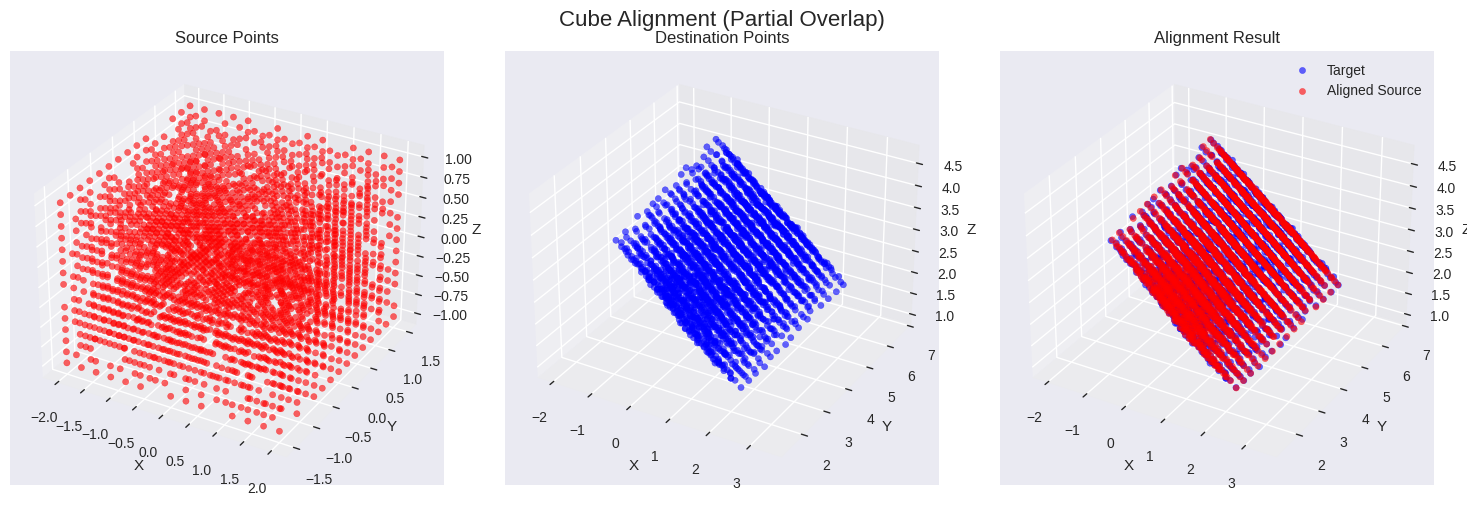

Mean alignment error: 0.031963
Max alignment error: 0.092083
RMSE: 0.034734


In [39]:
print("=== CUBE ALIGNMENT TEST (Partial Overlap) ===")

# Generate cube points
grid = np.linspace(-1, 1, 15)
X, Y, Z = np.meshgrid(grid, grid, grid)
src_cube = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T
src_cube = src_cube * np.array([2, 1.5, 1])  # Scale differently in each dimension

# Apply transformation
T_true = random_rigid_transform()
dst_cube_full = apply_transform(src_cube, T_true)

# Simulate partial overlap (80% of points)
mask = np.random.choice([True, False], size=(src_cube.shape[0],), p=[0.8, 0.2])
src_cube_partial = src_cube[mask]
dst_cube_partial = dst_cube_full[mask]

# Add noise
noise = np.random.normal(scale=0.02, size=dst_cube_partial.shape)
dst_cube_noisy = dst_cube_partial + noise

# Run einit algorithm for the timing stats
stmt = "\nellipsoid_init_icp(src_cube_partial, dst_cube_noisy)"
times = timeit.repeat(stmt, globals=globals(), repeat=1000, number=1)

# Convert to ms per call
ms_per_call = np.array(times) / 100 * 1e3
mean_ms = ms_per_call.mean()
std_ms  = ms_per_call.std()
print(f"\nellipsoid_init_icp (cube): {mean_ms:.3f} ms ± {std_ms:.3f} ms over 1000 runs")

# Run einit algorithm for the visuals
T_init = ellipsoid_init_icp(src_cube_partial, dst_cube_noisy)
aligned_cube = apply_transform(src_cube_partial, T_init)

print(f"\nUsing {src_cube_partial.shape[0]} out of {src_cube.shape[0]} points ({100*src_cube_partial.shape[0]/src_cube.shape[0]:.1f}%)")
print("\nTrue transformation matrix:")
print(T_true)
print("\nEstimated transformation matrix:")
print(T_init)

plot_point_clouds(src_cube_partial, dst_cube_noisy, aligned_cube, "Cube Alignment (Partial Overlap)")

=== BUNNY ALIGNMENT TEST ===

ellipsoid_init_icp (bunny): 0.101 ms ± 0.190 ms over 1000 runs

Using 812 of 992 points (81.9%)

True transform:
 [[-0.64650237  0.59379308  0.47900362  3.51864175]
 [ 0.42166772 -0.24512809  0.87298829  2.92548741]
 [ 0.63579165  0.76636936 -0.09190748 -0.57245714]
 [ 0.          0.          0.          1.        ]]

Estimated transform:
 [[-0.65351638  0.58959023  0.47465746  3.5191701 ]
 [ 0.40992843 -0.25147704  0.87676563  2.92540931]
 [ 0.63629791  0.76755629 -0.07734543 -0.57275624]
 [ 0.          0.          0.          1.        ]]


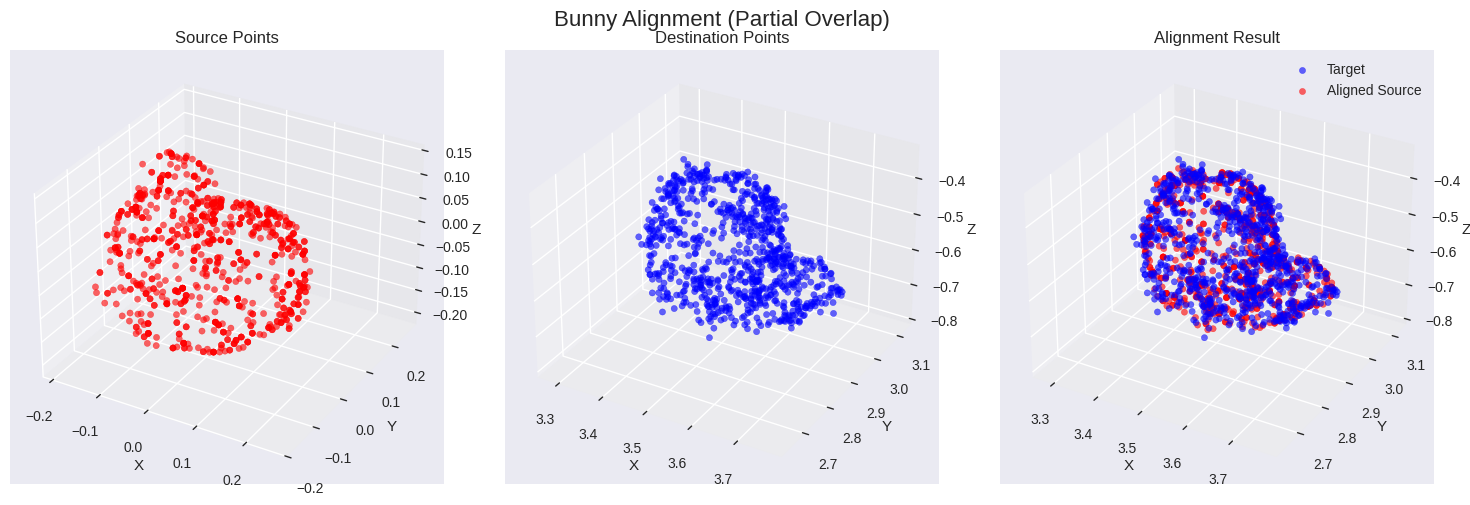

Mean alignment error: 0.016026
Max alignment error: 0.039212
RMSE: 0.017366


In [40]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

print("=== BUNNY ALIGNMENT TEST ===")

# Download the unoccluded Stanford Bunny point cloud
url = 'https://data.nrel.gov/system/files/153/bunny.csv'
with urllib.request.urlopen(url) as resp:
    bunny = np.loadtxt(resp, delimiter=',')
src_bunny = bunny[:, :3]  # only x,y,z columns

# Apply a random rigid transform and simulate partial overlap + noise
T_true = random_rigid_transform()
dst_full = apply_transform(src_bunny, T_true)

# Keep 80% of points for partial overlap
mask = np.random.rand(src_bunny.shape[0]) < 0.8
src_partial = src_bunny[mask]
dst_partial = dst_full[mask]

# Add small Gaussian noise
noise = np.random.normal(scale=0.01, size=dst_partial.shape)
dst_noisy = dst_partial + noise

# Run einit algorithm for the timing stats
timer = timeit.Timer(lambda: ellipsoid_init_icp(src_partial, dst_noisy))
times = np.array(timer.repeat(repeat=1000, number=1))
ms_per_call = times / 10 * 1e3                         # ms per single run

mean_ms = ms_per_call.mean()
std_ms  = ms_per_call.std(ddof=1)
print(f"\nellipsoid_init_icp (bunny): {mean_ms:.3f} ms ± {std_ms:.3f} ms over 1000 runs")

# Run einit algorithm for the visuals
T_init = ellipsoid_init_icp(src_partial, dst_noisy)
aligned_bunny = apply_transform(src_partial, T_init)

pct = 100 * src_partial.shape[0] / src_bunny.shape[0]
print(f"\nUsing {src_partial.shape[0]} of {src_bunny.shape[0]} points ({pct:.1f}%)")
print("\nTrue transform:\n", T_true)
print("\nEstimated transform:\n", T_init)

plot_point_clouds(src_partial, dst_noisy, aligned_bunny, title="Bunny Alignment (Partial Overlap)")


### Test 4 - Performance Analysis

=== PERFORMANCE ANALYSIS ===
Size   100:   0.580 ms ± 0.026 ms (95% CI)
Size   500:   0.705 ms ± 0.017 ms (95% CI)
Size  1000:   0.577 ms ± 0.018 ms (95% CI)
Size  2500:   0.741 ms ± 0.014 ms (95% CI)
Size  5000:   1.713 ms ± 0.048 ms (95% CI)
Size 10000:   2.924 ms ± 0.069 ms (95% CI)


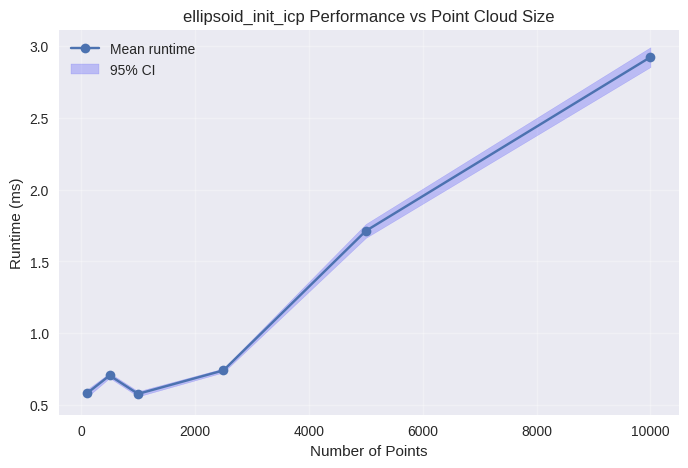

In [45]:
import timeit
import numpy as np
import matplotlib.pyplot as plt

print("=== PERFORMANCE ANALYSIS ===")

# Test different point cloud sizes
sizes = [100, 500, int(1e+3), int(2.5e+3), int(5e+3), int(1e+4)]
means = []
cis   = []
repeats = 1000  # number of timing runs per size

for size in sizes:
    # Generate test data once per size
    phi = np.random.uniform(0, np.pi, size)
    theta = np.random.uniform(0, 2*np.pi, size)
    src = np.vstack([
        np.sin(phi) * np.cos(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(phi)
    ]).T * 3

    T_true = random_rigid_transform()
    dst = apply_transform(src, T_true)
    noise = np.random.normal(scale=0.02, size=dst.shape)
    dst_noisy = dst + noise

    # Build a Timer that calls our init
    timer = timeit.Timer(lambda: ellipsoid_init_icp(src, dst_noisy))
    raw_times = np.array(timer.repeat(repeat=repeats, number=1))  # seconds per run
    times_ms = raw_times * 1000  # convert to ms

    mean_ms = times_ms.mean()
    std_ms  = times_ms.std(ddof=1)
    sem = std_ms / np.sqrt(repeats)
    ci95 = 1.96 * sem

    means.append(mean_ms)
    cis.append(ci95)

    print(f"Size {size:5d}: {mean_ms:7.3f} ms ± {ci95:5.3f} ms (95% CI)")

# Plot performance with 95%-confidence band
plt.figure(figsize=(8,5))
means = np.array(means)
cis   = np.array(cis)

plt.plot(sizes, means, 'o-', label='Mean runtime')
plt.fill_between(sizes, means - cis, means + cis,
                 color='blue', alpha=0.2, label='95% CI')
plt.xlabel('Number of Points')
plt.ylabel('Runtime (ms)')
plt.title('ellipsoid_init_icp Performance vs Point Cloud Size')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### Test 5 - Error Analysis

=== NOISE ROBUSTNESS ANALYSIS ===
Noise std 0.01: 0.023204 ± 0.001226 (95% CI)
Noise std 0.02: 0.046822 ± 0.003910 (95% CI)
Noise std 0.05: 0.114184 ± 0.004749 (95% CI)
Noise std 0.10: 0.232199 ± 0.010784 (95% CI)
Noise std 0.20: 0.466689 ± 0.017614 (95% CI)
Noise std 0.30: 0.670484 ± 0.020785 (95% CI)
Noise std 0.40: 0.906150 ± 0.023117 (95% CI)
Noise std 0.50: 1.103169 ± 0.025961 (95% CI)


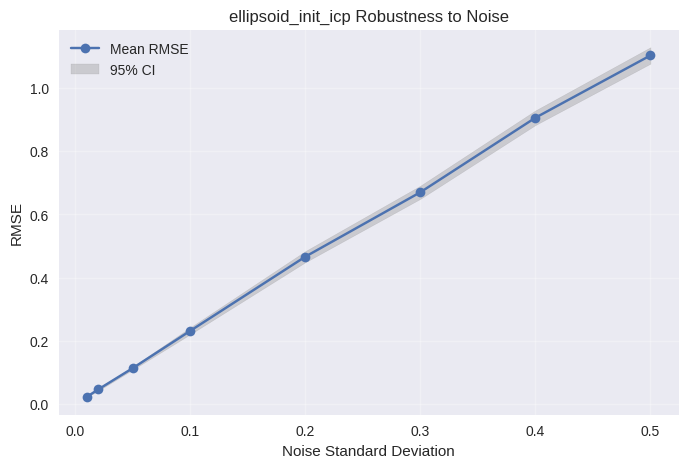

In [42]:
import numpy as np
import matplotlib.pyplot as plt

print("=== NOISE ROBUSTNESS ANALYSIS ===")

# Noise levels to test
noise_levels = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

# Number of independent runs per noise level
repeats = 1000

means = []
cis   = []

for noise_std in noise_levels:
    rmse_vals = []
    for _ in range(repeats):
        # Generate fresh sphere data
        phi = np.random.uniform(0, np.pi, 300)
        theta = np.random.uniform(0, 2*np.pi, 300)
        src = np.vstack([
            np.sin(phi) * np.cos(theta),
            np.sin(phi) * np.sin(theta),
            np.cos(phi)
        ]).T * 3

        # Apply ground-truth rigid transform
        T_true = random_rigid_transform()
        dst_clean = apply_transform(src, T_true)

        # Add noise
        noise = np.random.normal(scale=noise_std, size=dst_clean.shape)
        dst_noisy = dst_clean + noise

        # Run ellipsoid init
        T_est = ellipsoid_init_icp(src, dst_noisy)
        aligned = apply_transform(src, T_est)

        # Compute RMSE
        diff = aligned - dst_noisy
        rmse = np.sqrt(np.mean(np.sum(diff**2, axis=1)))
        rmse_vals.append(rmse)

    rmse_arr = np.array(rmse_vals)
    mean_rmse = rmse_arr.mean()
    sem       = rmse_arr.std(ddof=1) / np.sqrt(repeats)
    ci95      = 1.96 * sem

    means.append(mean_rmse)
    cis.append(ci95)

    print(f"Noise std {noise_std:4.2f}: {mean_rmse:.6f} ± {ci95:.6f} (95% CI)")

# Plot mean RMSE with 95% confidence band
means = np.array(means)
cis   = np.array(cis)

plt.figure(figsize=(8,5))
plt.plot(noise_levels, means, 'o-', label='Mean RMSE')
plt.fill_between(noise_levels, means - cis, means + cis,
                 color='gray', alpha=0.3, label='95% CI')
plt.xlabel('Noise Standard Deviation')
plt.ylabel('RMSE')
plt.title('ellipsoid_init_icp Robustness to Noise')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
